### Reconhecimentos de Imagens com Deep Learning Utilizando TensorFlow e Keras
[Reconhecimento de Imagens com Deep Learning usando TensorFlow e Keras // Mão no Código by Red Hat #8](https://www.youtube.com/watch?v=7MItgjXU3_E)

In [65]:
#jupyter notebook --no-browser --NotebookApp.allow_origin='*'
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

In [66]:
!curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -o cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10 65.4M   10 6781k    0     0  6654k      0  0:00:10  0:00:01  0:00:09 6655k
 26 65.4M   26 17.6M    0     0  8929k      0  0:00:07  0:00:02  0:00:05 8930k
 43 65.4M   43 28.6M    0     0  9707k      0  0:00:06  0:00:03  0:00:03 9708k
 60 65.4M   60 39.6M    0     0   9.8M      0  0:00:06  0:00:04  0:00:02  9.8M
 77 65.4M   77 50.6M    0     0  10.0M      0  0:00:06  0:00:05  0:00:01 10.1M
 92 65.4M   92 60.2M    0     0  10.0M      0  0:00:06  0:00:06 --:--:-- 10.7M
100 65.4M  100 65.4M    0     0  10.0M      0  0:00:06  0:00:06 --:--:-- 10.7M


In [67]:
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()
os.remove(local_zip)

In [68]:
dataset_dir = './cats_and_dogs_filtered'
dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 1000
Train Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


### Definição dos parâmetros

In [69]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

In [70]:
batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['cat', 'dog']

### Criação do dataset de treinamento a partir do diretório de imagens

In [71]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


### Criação do dataset de validação a partir do diretório de imagens

In [72]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = (image_width, image_height),
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


### Obtenção de dados dos datasets obtidos

In [73]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 26
Test Dataset Cardinality: 6


In [74]:
autotune = tf.data.AUTOTUNE

dataset_train = dataset_train.prefetch(buffer_size = autotune)
dataset_validation = dataset_validation.prefetch(buffer_size = autotune)
dataset_test = dataset_validation.prefetch(buffer_size = autotune)

### Função de plot do dataset

In [75]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

Train Dataset


<Figure size 640x480 with 0 Axes>

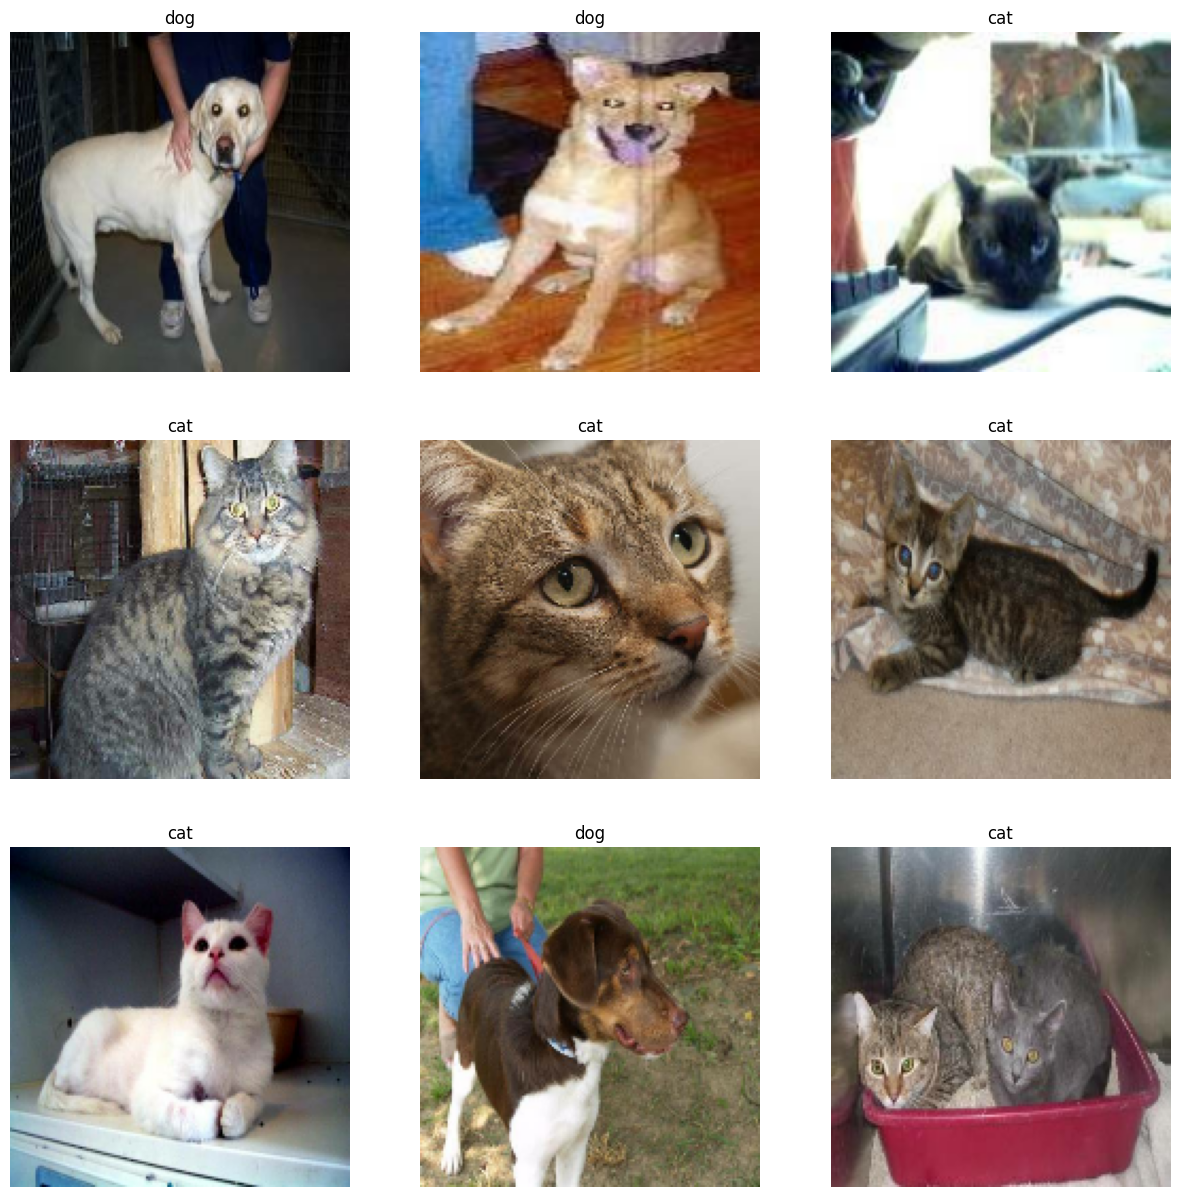

In [76]:
print('Train Dataset')
plot_dataset(dataset_train)

Validation Dataset


<Figure size 640x480 with 0 Axes>

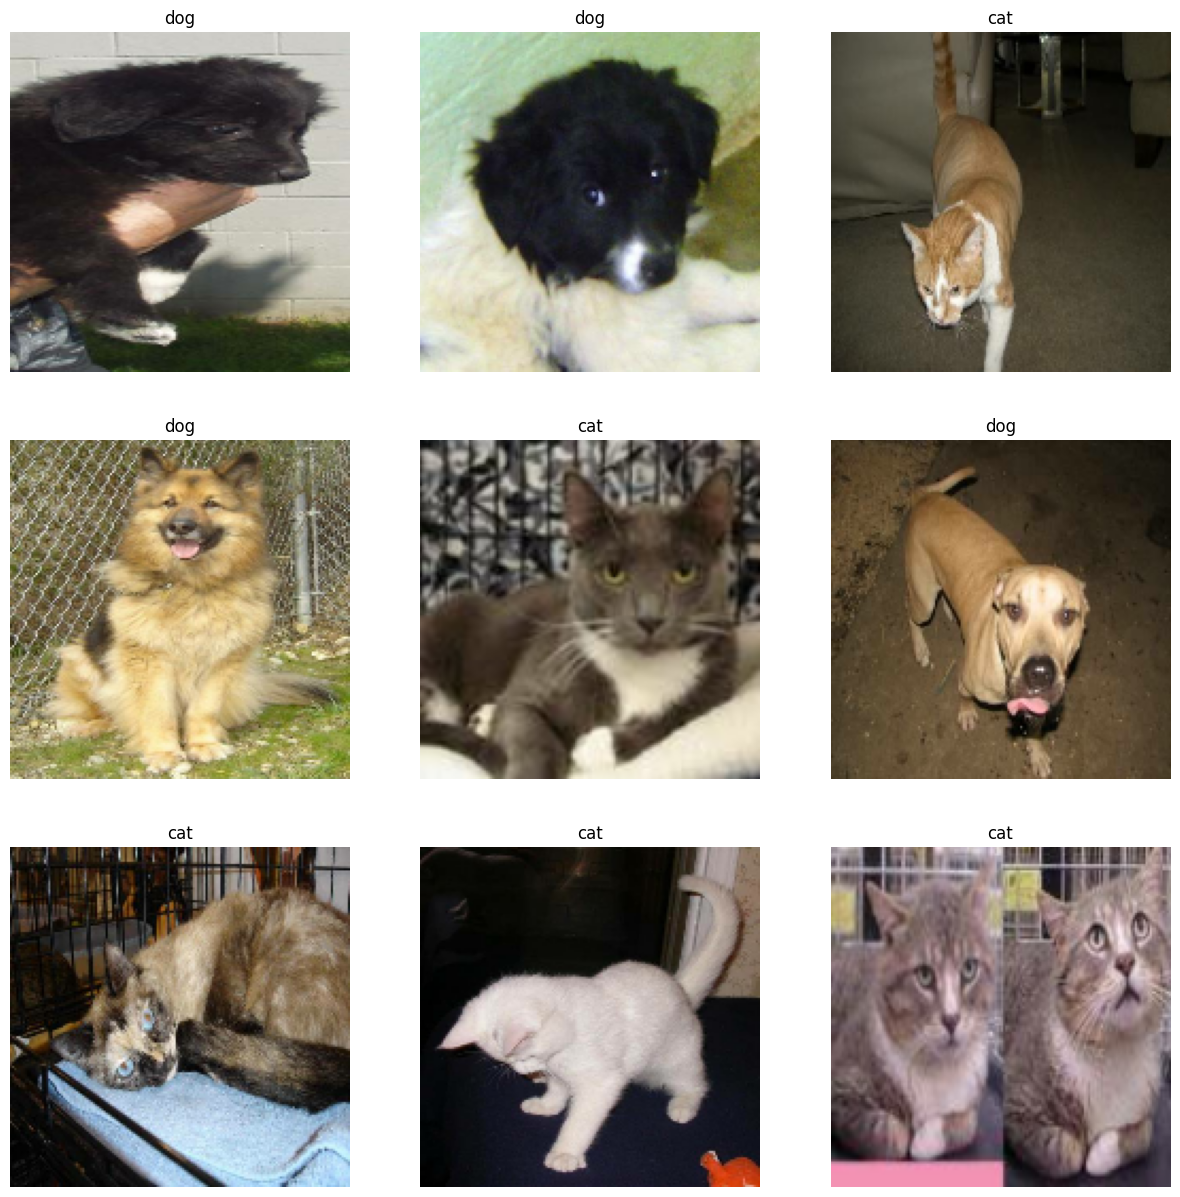

In [77]:
print('Validation Dataset')
plot_dataset(dataset_validation)

Test Dataset


<Figure size 640x480 with 0 Axes>

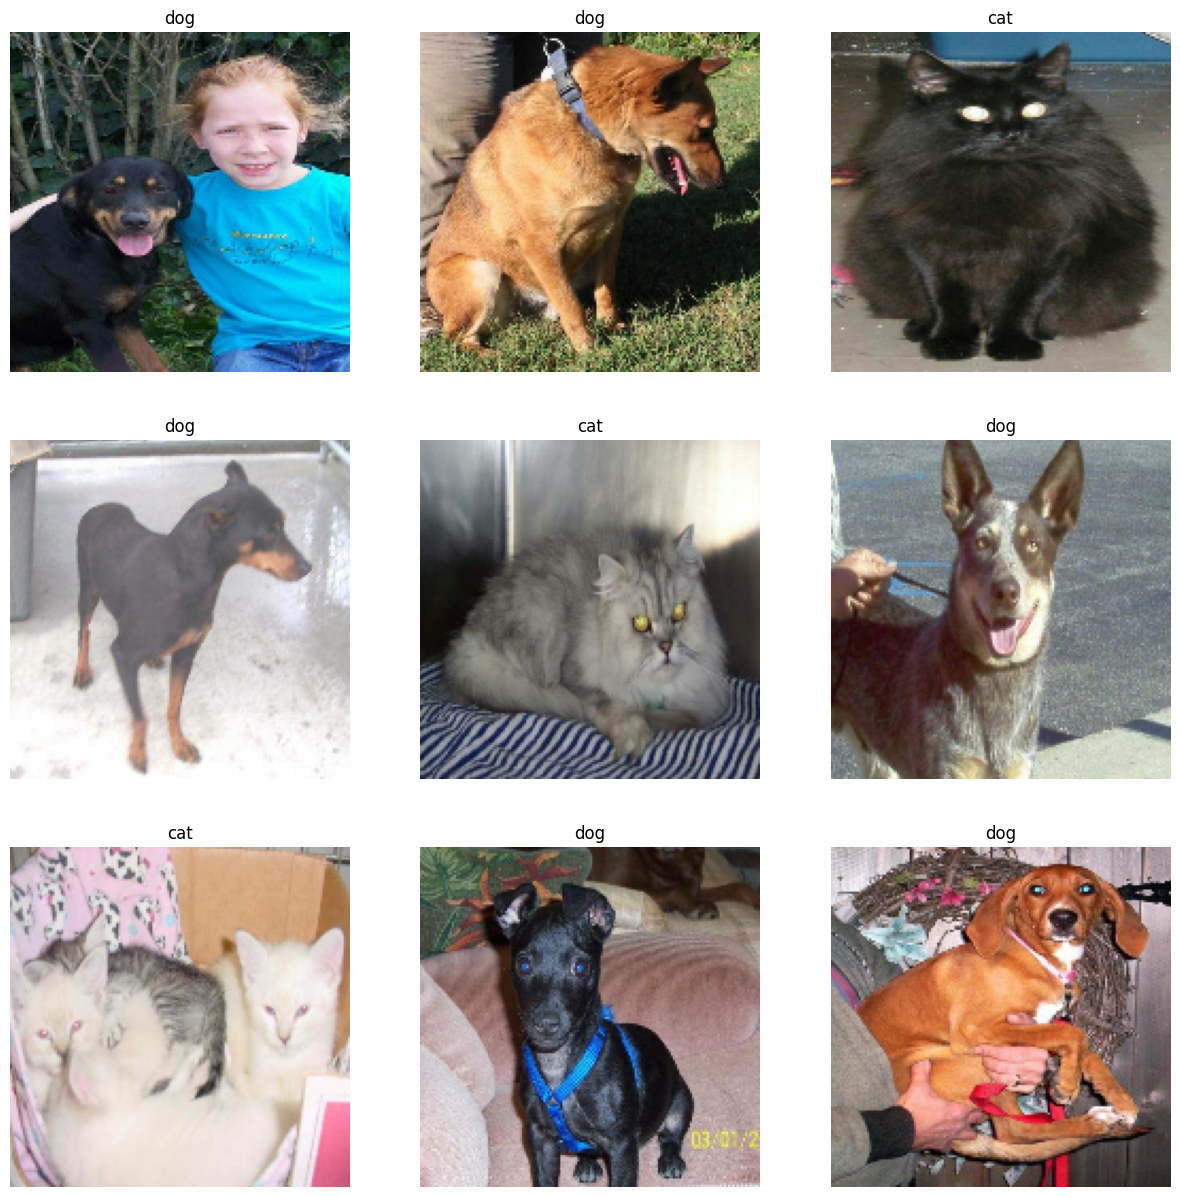

In [78]:
print('Test Dataset')
plot_dataset(dataset_test)

### Função de Data Augmentation
Função utilizada para gerar novas imagens a partir das imagens do dataset de treinamento, com o objetivo de aumentar a quantidade de imagens para treinamento e melhorar a acurácia do modelo.
Essa função rotaciona, inverte e aplica zoom nas imagens do dataset de treinamento.

In [79]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [80]:
def plot_dataset_data_augmentation(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, _ in dataset.take(1):

        feature = features[0]

        for i in range(9):

            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

In [81]:
#plot_dataset_data_augmentation(dataset_train)

In [82]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / image_color_channel_size, input_shape = image_shape),
    data_augmentation,
    tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(len(class_names))
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [83]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20
63/63 [==============================] - 38s 459ms/step - loss: 0.6957 - accuracy: 0.4840 - val_loss: 0.6883 - val_accuracy: 0.6126
Epoch 2/20
63/63 [==============================] - 17s 266ms/step - loss: 0.6838 - accuracy: 0.5700 - val_loss: 0.6733 - val_accuracy: 0.6064
Epoch 3/20
63/63 [==============================] - 16s 257ms/step - loss: 0.6526 - accuracy: 0.6125 - val_loss: 0.6433 - val_accuracy: 0.6163
Epoch 4/20
63/63 [==============================] - 14s 214ms/step - loss: 0.6309 - accuracy: 0.6445 - val_loss: 0.6210 - val_accuracy: 0.6411
Epoch 5/20
63/63 [==============================] - 13s 197ms/step - loss: 0.6186 - accuracy: 0.6550 - val_loss: 0.6060 - val_accuracy: 0.6473
Epoch 6/20
63/63 [==============================] - 14s 216ms/step - loss: 0.6045 - accuracy: 0.6795 - val_loss: 0.6492 - val_accuracy: 0.6139
Epoch 7/20
63/63 [==============================] - 12s 194ms/step - loss: 0.5962 - accuracy: 0.6780 - val_loss: 0.6273 - val_accuracy: 0.6374

## Plot de acurácia
```python	
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
```

## Função de loss
```python	
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
```

In [84]:
def plot_dataset_predictions(dataset):
    features, labels = dataset.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())
    
    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):
          
          plt.subplot(3, 3, i + 1)
          plt.axis('off')
  
          plt.imshow(features[i].astype('uint8'))
          plt.title(class_names[predictions[i]])

In [85]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

<Figure size 640x480 with 0 Axes>

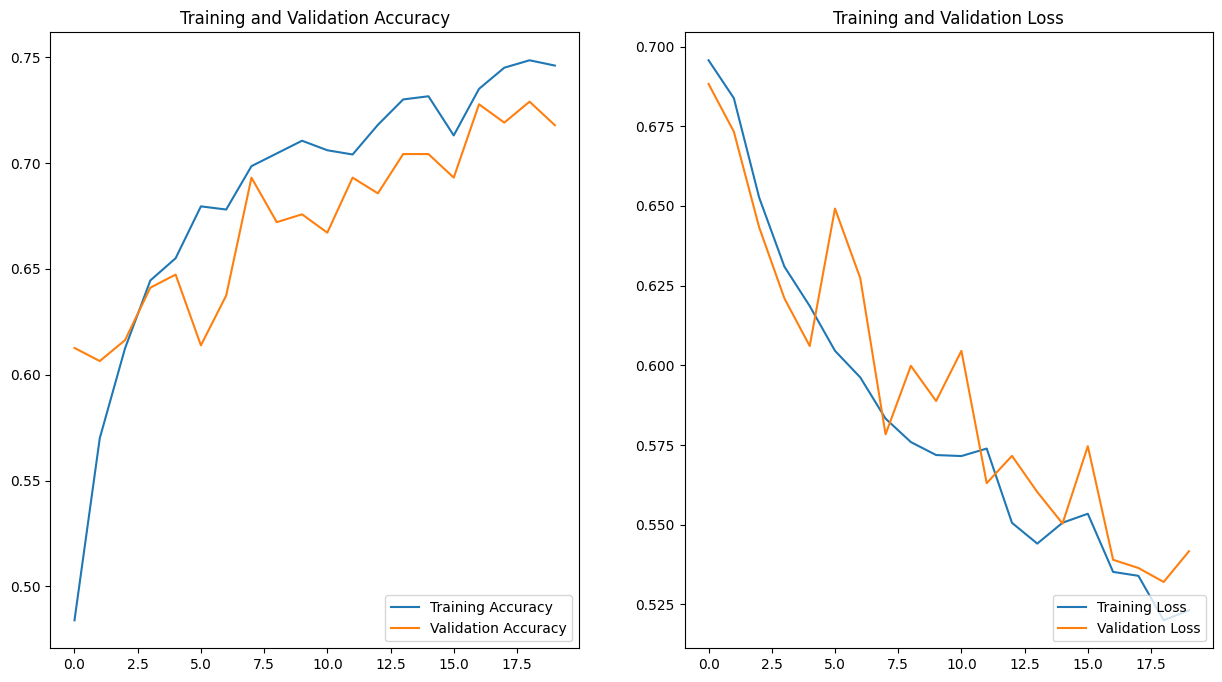

In [86]:
plot_model()

Labels:      [1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0]
Predictions: [0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0]


<Figure size 640x480 with 0 Axes>

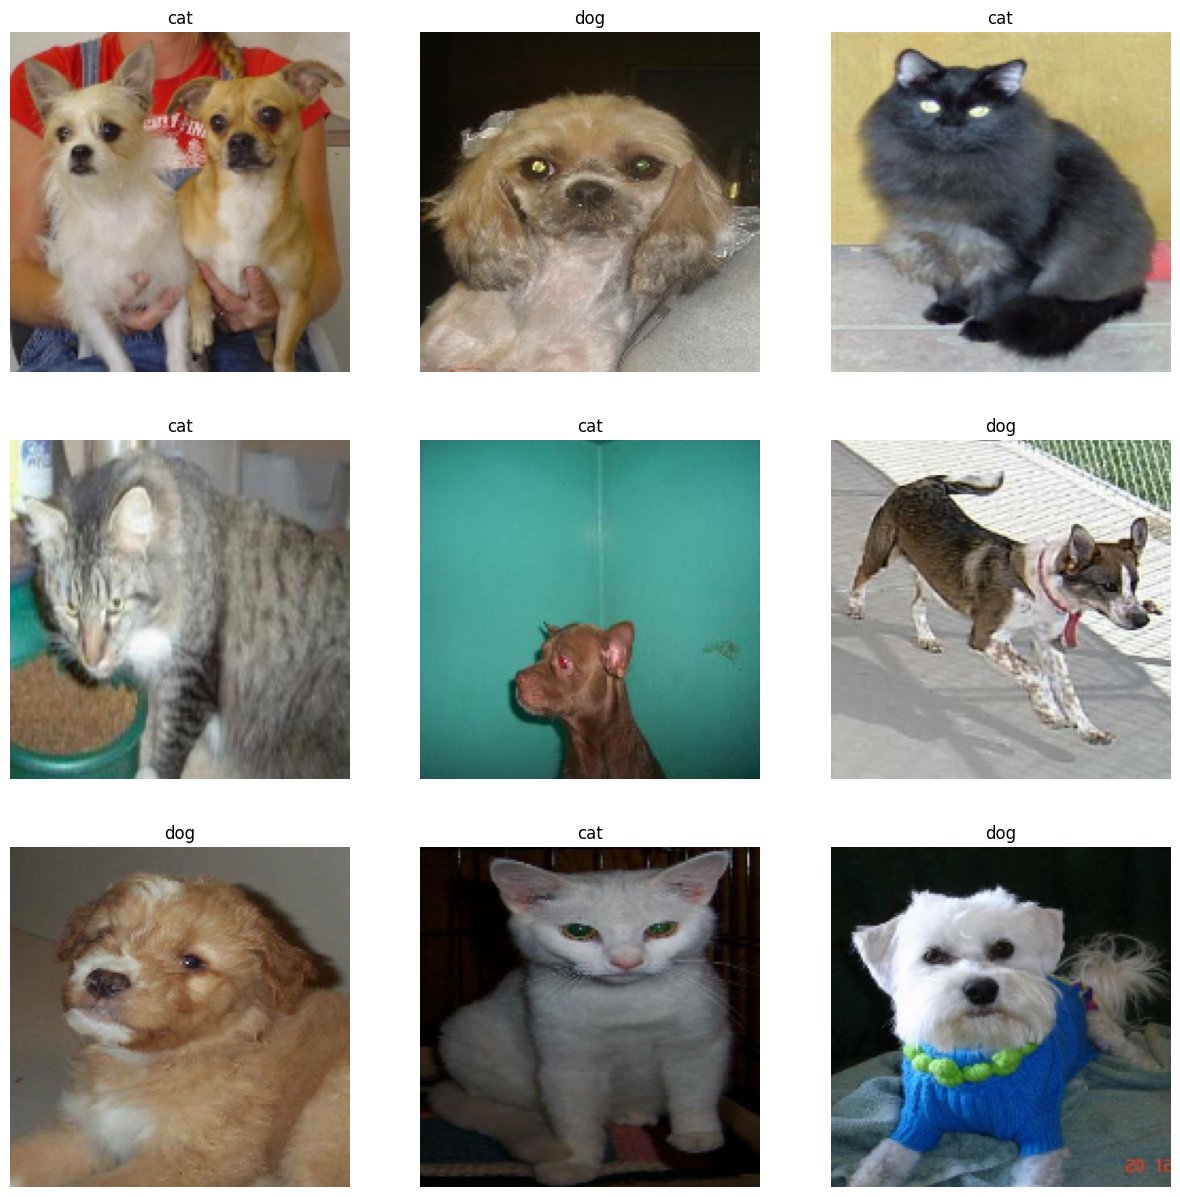

In [87]:
plot_dataset_predictions(dataset_test)

In [88]:
model.save('cats_and_dogs.h5')

### Para carregar um modelo:
```python
model = tf.keras.models.load_model('cats_and_dogs.h5')
```